We’ll build a federated learning system using the Flower framework, Flower Datasets and PyTorch.

*   In part 1, we will use *Pytorch for model training pipeine and data loading*.
*   In part 2, we will form the Pytorch project using Flower.



**Step 0: Preparation**

---



Install dependencies

In [ ]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480

In [ ]:
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
# disable_progress_bar controls the visibility of progress bars
from torch.utils.data import DataLoader
import flwr
from flwr_datasets import FederatedDataset

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.17.0 / PyTorch 2.6.0+cu124


Load the data





1.   We're using Federated Learning by training CNN on MNIST dataset.
2.   Each organization will act as a client in the federated learning system.
3.   We're using the Flower Datasets library *(flwr-datasets)* to partition *MNIST* using FederatedDataset. We'll create train and test set for each organization and give them to *PyTorch DataLoader*.



In [ ]:
NUM_CLIENTS=10
fds=FederatedDataset(dataset="mnist", partitioners={"train": NUM_CLIENTS})
fds

In [ ]:
fds.partitioners

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

{'train': <flwr_datasets.partitioner.iid_partitioner.IidPartitioner at 0x7a2410f90e50>}

In [ ]:
NUM_CLIENTS = 10
BATCH_SIZE = 32
# partition_id refers to client (0-9)
def load_datasets(partition_id: int):
    fds = FederatedDataset(dataset="mnist", partitioners={"train": NUM_CLIENTS}) #fds will contain the federated version of the CIFAR-10
    partition = fds.load_partition(partition_id)
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5,), (0.5,)) # Normalize(mean,std_dev)
        ]
    )

    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]] #batch["img"] refers to list of images
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)

    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True # Retrieve training partition of the dataset from partition_train_test
    )
    valloader = DataLoader(
        partition_train_test["test"], batch_size=BATCH_SIZE
    )

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(
        testset, batch_size=BATCH_SIZE
    )
    return trainloader, valloader, testloader

In [ ]:
total_train = fds.load_split("train")
print(len(total_train))
total_test = fds.load_split("test")
print(len(total_test))

60000
10000


In [ ]:
fds = FederatedDataset(dataset="mnist", partitioners={"train": NUM_CLIENTS})
partition = fds.load_partition(1)
partition_train_test = partition.train_test_split(test_size=0.2, seed=42)

def apply_transforms(batch):
    batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
    return batch

trainloader = DataLoader(
    partition_train_test["train"],
    batch_size=BATCH_SIZE,
    shuffle=True
)
valloader = DataLoader(
    partition_train_test["test"], batch_size=BATCH_SIZE
)

testset = fds.load_split("test").with_transform(apply_transforms)
testloader = DataLoader(
    testset, batch_size=BATCH_SIZE
)
print(trainloader)  # Print DataLoader object reference
print(valloader)
print(testloader)

In [ ]:
print(len(partition))
print(len(partition_train_test["train"]))
print(len(partition_train_test["test"]))

6000
4800
1200


In [ ]:
fds.load_partition(1)

Dataset({
    features: ['image', 'label'],
    num_rows: 6000
})

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

pytorch_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL.Image to Tensor
    transforms.Normalize((0.5,), (0.5,))
])

def apply_transforms(batch):
    batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
    return batch

partition_train_test = partition_train_test.with_transform(apply_transforms)

BATCH_SIZE = 32
trainloader = DataLoader(
    partition_train_test["train"],
    batch_size=BATCH_SIZE,
    shuffle=True
)
valloader = DataLoader(
    partition_train_test["test"],
    batch_size=BATCH_SIZE
)
testset = fds.load_split("test").with_transform(apply_transforms)
testloader = DataLoader(
    testset,
    batch_size=BATCH_SIZE
)

for batch in trainloader:
    print(batch)
    break

{'image': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
      

In [ ]:
for batch in trainloader:
  print(batch['image'][0])
  print(batch['image'][0].shape)
  print(batch['label'][0])
  break

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

In [ ]:
print(len(trainloader.dataset))
print(len(trainloader)) # 32*len(trainloader)=4800

4800
150


In [ ]:
for batch in trainloader:
    print("Image batch shape:", batch['image'].shape)
    print("Label batch shape:", batch['label'].shape)
    break

Image batch shape: torch.Size([32, 1, 28, 28])
Label batch shape: torch.Size([32])


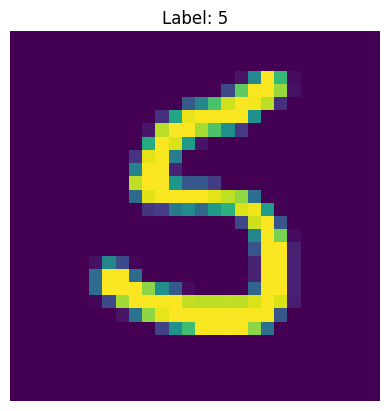

In [ ]:
import matplotlib.pyplot as plt
import torchvision

image = batch['image'][31]
label = batch['label'][31]

image = image*0.5+0.5

plt.imshow(image.permute(1,2,0).numpy())
plt.title(f"Label: {label.item()}")
plt.axis('off')
plt.show()

In [ ]:
def count_images(loader):
    total_images = 0
    for batch in loader:
        total_images += len(batch['image'])
    return total_images

train_images = count_images(trainloader)
val_images = count_images(valloader)
test_images = count_images(testloader)
print(f"Total images in trainloader: {train_images}")
print(f"Total images in valloader: {val_images}")
print(f"Total images in testloader: {test_images}")

Total images in trainloader: 4800
Total images in valloader: 1200
Total images in testloader: 10000


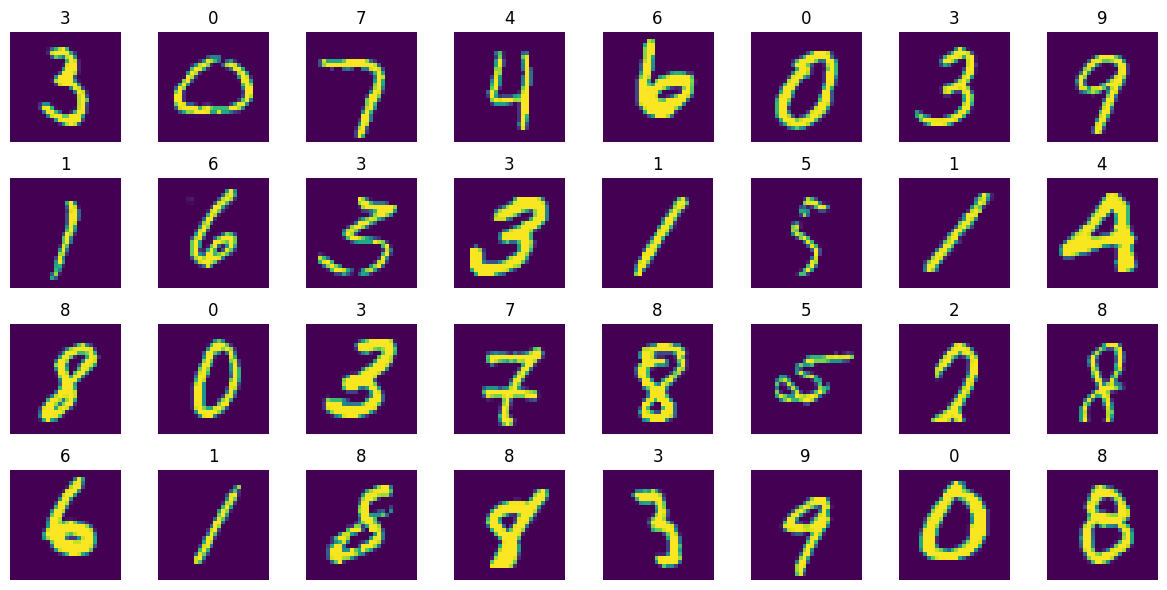

In [ ]:
trainloader, _, _ = load_datasets(partition_id=0)
batch = next(iter(trainloader))
# iter(trainloader): Converts the trainloader into an iterator which can be used to fetch batches of data one by one.
# next(): Fetches the next batch of data from the iterator.
# batch = next(iter(trainloader)) fetches one batch of data from the trainloader.
images, labels = batch["image"], batch["label"]

images = images.permute(0, 2, 3, 1).numpy() # [Batch, Channels, Height, Width] → [Batch, Height, Width, Channels]
images = images / 2 + 0.5 # denormalise

fig, axs = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

fig.tight_layout()
plt.show()

In [ ]:
from collections import Counter

NUM_CLIENTS = 10
NUM_CLASSES = 10

total_counts_client_class = np.zeros((NUM_CLASSES, NUM_CLIENTS)) # (10*10)
for client_id in range(NUM_CLIENTS):
    trainloader, _, _ = load_datasets(client_id)
    label_list = []
    for batch in trainloader:
        labels = batch["label"] # 32 sized tensor and converting it into list by labels.tolist() & appending it to label_list
        label_list.extend(labels.tolist())
    class_counts = Counter(label_list)
    # Counter(label_list) is a dictionary to store one client has how many objects of 10 classes
    for cls in range(NUM_CLASSES):
        total_counts_client_class[cls][client_id] = class_counts.get(cls, 0)

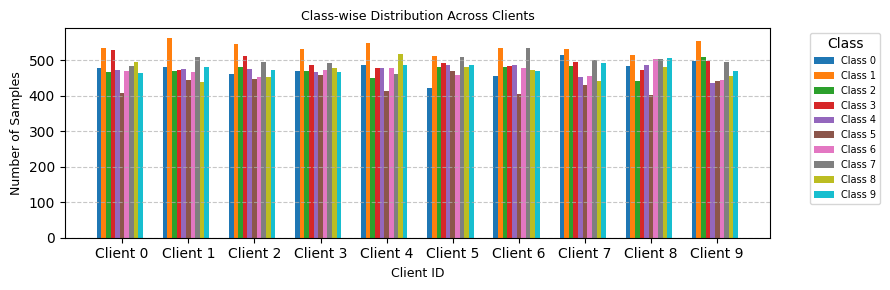

In [ ]:
x=np.arange(NUM_CLIENTS)
bar_width=0.07

plt.figure(figsize=(9,3))

for cls in range(NUM_CLASSES):
    plt.bar(x+cls*bar_width,total_counts_client_class[cls],width=bar_width,label=f'Class {cls}')

plt.xlabel("Client ID", fontsize=9)
plt.ylabel("Number of Samples", fontsize=9)
plt.title("Class-wise Distribution Across Clients", fontsize=9)
plt.xticks(x+bar_width*NUM_CLASSES/2, [f"Client {i}" for i in range(NUM_CLIENTS)])
plt.legend(title="Class",bbox_to_anchor=(1.05,1),loc="upper left",fontsize=7)
plt.grid(axis='y',linestyle='--',alpha=0.7)
plt.tight_layout()
plt.show()